<a id='Data_loading'></a>
## **1. Data Loading and Cleaning** ##

In [215]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

heart = pd.read_csv("./Data/processed.cleveland.csv")
heart.info()
heart.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null object
thal        303 non-null object
target      303 non-null int64
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


(303, 14)

In [216]:
heart.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [217]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


## Features Description

1. **Age**: displays the age of the individual.
2. **Sex**: displays the gender of the individual using the following format :

    1 = male, 0 = female

3. **Chest-pain type (cp)**: displays the type of chest-pain experienced by the individual using the following format :

    1 = typical angina, 2 = atypical angina, 3 = non — anginal pain, 4 = asymptotic

4. **Resting Blood Pressure (trestbps)**: displays the resting blood pressure value of an individual in mmHg (unit)
5. **Serum Cholestrol (chol)**: displays the serum cholesterol in mg/dl (unit)
6. **Fasting Blood Sugar (fbs)**: compares the fasting blood sugar value of an individual with 120mg/dl.

    If fasting blood sugar > 120mg/dl then : 1 (true), else : 0 (false)
7. **Resting ECG (restecg)**: displays resting electrocardiographic results

    0 = normal, 1 = having ST-T wave abnormality, 2 = left ventricular hyperthrophy

8. **Max heart rate achieved (thalch)**: displays the max heart rate achieved by an individual.
9. **Exercise induced angina (exang)**:

    0 = no

10. **ST depression induced by exercise relative to rest (old peak)**: displays the value which is an integer or float.
11. **Peak exercise ST segment (slope)**:

    1 = upsloping, 2 = flat, 3 = downsloping

12. **Number of major vessels (0–3) colored by flourosopy (ca)**: displays the value as integer or float.
13. **Thalassemia (thal)**: displays the thalassemia :

    3 = normal, 6 = fixed defect, 7 = reversible defect

14. **Diagnosis of heart disease (target)**: Displays whether the individual is suffering from heart disease or not :

    0 = absence, 1, 2, 3, 4 = present.

In [218]:
# rename columns
heart.columns = ['age', 'sex', 'chest_pain_type', 'rest_BP', 'cholesterol', 'fast_blood_sugar', 'rest_ECG', 'max_HR', 'ex_induced_angina', 
               'ST_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [219]:
# label the levels of categorical features

heart['sex'] = ['Male' if s else 'Female' for s in heart['sex']] # label sex columns
heart['target'] = [0 if t == 0 else 1 for t in heart['target']] # change target to binary
heart['chest_pain_type'] = heart['chest_pain_type'].astype('category').cat.rename_categories(['asymptomatic', 'typical angina','atypical', 'anginanon-anginal'])
heart['fast_blood_sugar'] = heart['fast_blood_sugar'].astype('category').cat.rename_categories(['lower than 120mg/dl', 'higher than 120mg/dl'])
heart['rest_ECG'] = heart['rest_ECG'].astype('category').cat.rename_categories(['left ventricular hypertrophy', 'normal', 'ST-T wave abnormality'])
heart['ex_induced_angina'] = heart['ex_induced_angina'].astype('category').cat.rename_categories(['no', 'yes'])
heart['st_slope'] = heart['st_slope'].astype('category').cat.rename_categories(['downslope', 'flat', 'upslope'])
# replace '?' in thalassemia with median
heart.thalassemia = heart.thalassemia.replace('?', None)
heart.thalassemia = heart.thalassemia.replace('None', heart['thalassemia'].median())
heart['thalassemia'] = heart['thalassemia'].astype('category').cat.rename_categories(['normal', 'fixed defect', 'reversable defect'])

<a id='EDA'></a>
## **2. Exploratory Data Analysis** ##

In [221]:
heart.head()

,age,sex,chest_pain_type,rest_BP,cholesterol,fast_blood_sugar,rest_ECG,max_HR,ex_induced_angina,ST_depression,st_slope,num_major_vessels,thalassemia,target
0,63,Male,asymptomatic,145,233,higher than 120mg/dl,ST-T wave abnormality,150,no,2.3,upslope,0,fixed defect,0
1,67,Male,anginanon-anginal,160,286,lower than 120mg/dl,ST-T wave abnormality,108,yes,1.5,flat,3,normal,1
2,67,Male,anginanon-anginal,120,229,lower than 120mg/dl,ST-T wave abnormality,129,yes,2.6,flat,2,reversable defect,1
3,37,Male,atypical,130,250,lower than 120mg/dl,left ventricular hypertrophy,187,no,3.5,upslope,0,normal,0
4,41,Female,typical angina,130,204,lower than 120mg/dl,ST-T wave abnormality,172,no,1.4,downslope,0,normal,0


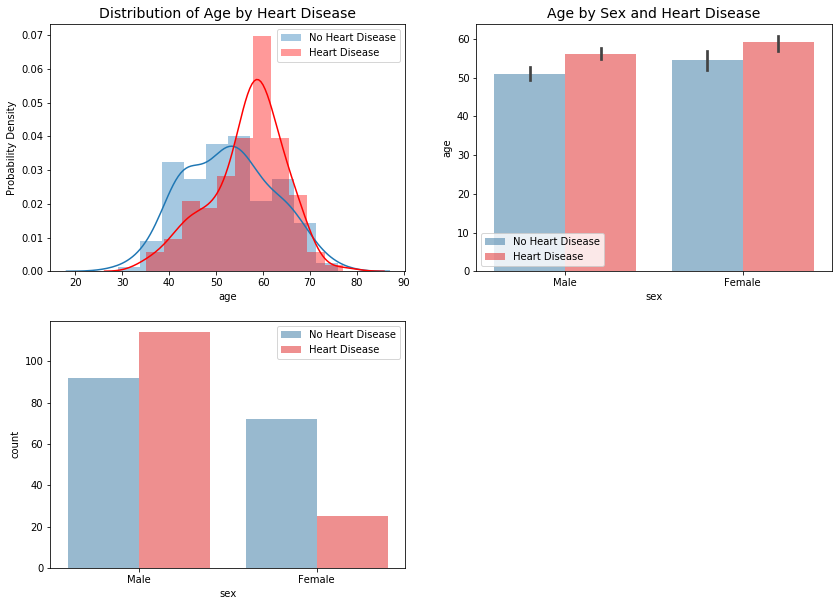

In [223]:
fig = plt.figure(figsize=(14,10))

# Distribution of Age by Heart Disease
ax1 = fig.add_subplot(221)
plt.title('Distribution of Age by Heart Disease', fontsize=14)
sns.distplot(heart[heart['target']==0].age, label='No Heart Disease', ax=ax1)
sns.distplot(heart[heart['target']==1].age, label='Heart Disease', color='red', ax=ax1)
plt.ylabel('Probability Density')
plt.legend()

# Age by Sex and Heart Disease
ax2 = fig.add_subplot(222)
plt.title('Age by Sex and Heart Disease', fontsize=14)
sns.catplot(x='sex', y='age', data=heart, hue='target', palette={0:'tab:blue',1:'red'}, alpha=.5, kind='bar', ax=ax2)
handles, labels = ax2.get_legend_handles_labels() # get the handles of subplot
ax2.legend(handles=handles, labels=['No Heart Disease', 'Heart Disease'])

# Frequency of Heart Disease by Sex
ax3 = fig.add_subplot(223)
plt.title('Frequency of Heart Disease by Sex', fontsize=14)
sns.countplot(x="sex", hue="target", palette={0:'tab:blue',1:'red'}, alpha=.5, data=heart, ax=ax3)
plt.legend(labels=['No Heart Disease', 'Heart Disease'])
ax3.legend(handles=handles, labels=['No Heart Disease', 'Heart Disease'])

plt.close(2)
plt.show()

In [ ]:
We can see that 

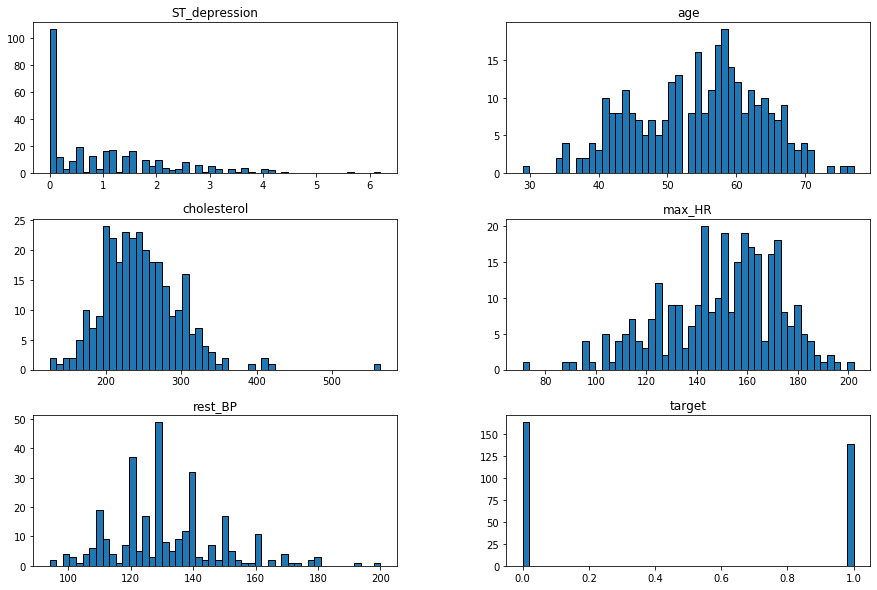

In [224]:
# Plot distribution for each variable
heart.hist(bins=50, figsize=(15, 10), grid=False, edgecolor='black')
plt.show()

ST_depression is highly skewed while cholesterol appears to have an extreme outlier that might need removal

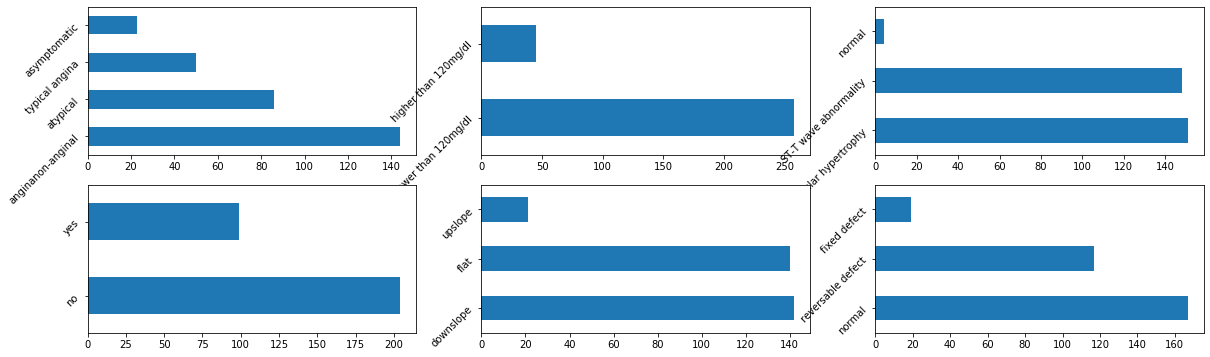

In [244]:
# Frequency plots for catergorical features
fig = plt.figure(figsize=(20,6))
for count, col in enumerate(heart.select_dtypes(include='category').columns):
    fig.add_subplot(2,3,count+1)
    heart[col].value_counts().plot.barh()
    plt.yticks(rotation=45)

<a id='Data_cleaning'></a>
## **3. Data Cleaning** ##

ECG ST segment [guide](http://litfl.com/st-segment-ecg-library/).

Thalsssemia will be left out of analyses as it is unclear what the numbers refer to.

Target: 0 = disease, 1 = no disease

0: typical angina
1: atypical angina
2: non-anginal pain
3: asymptomatic

Teget might be swapped